In [ ]:
!pip install transformers pandas torch

In [ ]:
import pandas as pd
import ast
from transformers import pipeline, M2M100ForConditionalGeneration, M2M100Tokenizer

In [ ]:
# Load your CSV file into a DataFrame
df = pd.read_csv("ca-de.csv")  # replace with your file name

In [ ]:
# Convert the string representation of the dictionary into an actual dictionary
df["translation_dict"] = df["translation"].apply(ast.literal_eval)

In [ ]:
# Initialize the multilingual translation model (M2M100) and tokenizer.
# M2M100 is designed to translate between 100 languages.
model_name = "facebook/m2m100_418M"
tokenizer = M2M100Tokenizer.from_pretrained(model_name)
model = M2M100ForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

In [ ]:
def translate_text(text, src_lang, tgt_lang="en"):
    """
    Translate text from src_lang to tgt_lang using the M2M100 model.
    """
    # Set the tokenizer's source language.
    tokenizer.src_lang = src_lang
    # Tokenize the input text.
    encoded = tokenizer(text, return_tensors="pt")
    # Generate translated tokens with the forced beginning-of-sentence token for the target language.
    generated_tokens = model.generate(**encoded, forced_bos_token_id=tokenizer.get_lang_id(tgt_lang))
    # Decode the generated tokens into a string.
    translated_text = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    return translated_text

In [ ]:
# Initialize a sentiment analysis pipeline using a pre-trained sentiment model.
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Process each row and each language version
results = []
for idx, row in df.iterrows():
    row_id = row["id"]
    translation_dict = row["translation_dict"]
    for lang_code, text in translation_dict.items():
        try:
            # Translate the text from its source language (e.g., 'ca' or 'de') to English.
            translated_text = translate_text(text, src_lang=lang_code, tgt_lang="en")
        except Exception as e:
            translated_text = None
            print(f"Translation failed for row {row_id} language {lang_code}: {e}")
        # If translation is successful, perform sentiment analysis.
        sentiment = sentiment_pipeline(translated_text)[0] if translated_text else None

        results.append({
            "id": row_id,
            "language": lang_code,
            "original_text": text,
            "translated_text": translated_text,
            "sentiment": sentiment
        })



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# Convert results into a DataFrame for easy viewing or further processing
result_df = pd.DataFrame(results)
print(result_df)

    id language                                      original_text  \
0    0       ca  Source: Project GutenbergTranslation: Josep Ca...   
1    0       de                          Source: Project Gutenberg   
2    1       ca                        Les Aventures De Tom Sawyer   
3    1       de                          Die Abenteuer Tom Sawyers   
4    2       ca                                         Mark Twain   
5    2       de                                         Mark Twain   
6    3       ca                                           PREFACI.   
7    3       de                                Vorwort des Autors.   
8    4       ca  La major part de les aventures consignades en ...   
9    4       de  Die meisten der hier erzählten Abenteuer haben...   
10   5       ca  Huck Finn és tret de la vida real; Tom Sawyer ...   
11   5       de  Huck Finn ist nach dem Leben gezeichnet, nicht...   
12   6       ca  Les estranyes supersticions a les quals hom fa...   
13   6       de  Ich

In [ ]:
result_df.head()

,id,language,original_text,translated_text,sentiment
0,0,ca,Source: Project GutenbergTranslation: Josep Ca...,Source: Project GutenbergTranslation by Josep ...,"{'label': 'NEGATIVE', 'score': 0.979826807975769}"
1,0,de,Source: Project Gutenberg,Source: Project Gutenberg,"{'label': 'POSITIVE', 'score': 0.9704182744026..."
2,1,ca,Les Aventures De Tom Sawyer,The Adventures of Tom Sawyer,"{'label': 'POSITIVE', 'score': 0.9985816478729..."
3,1,de,Die Abenteuer Tom Sawyers,The Adventures of Tom Sawyers,"{'label': 'POSITIVE', 'score': 0.998792290687561}"
4,2,ca,Mark Twain,by Mark Twain,"{'label': 'POSITIVE', 'score': 0.9979140162467..."


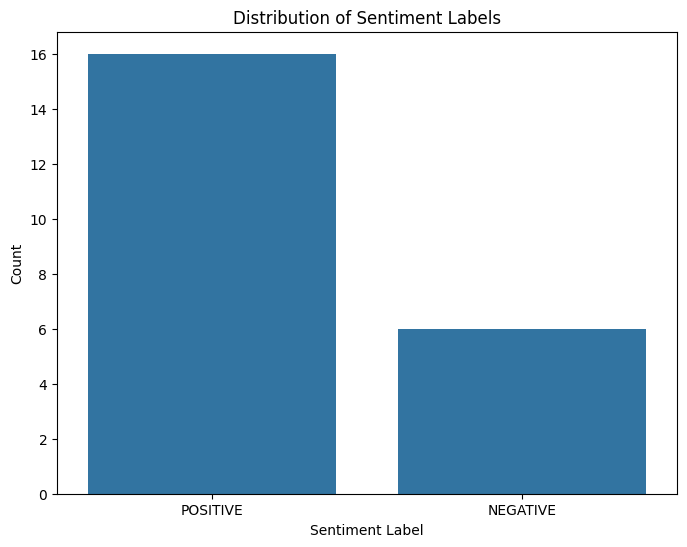

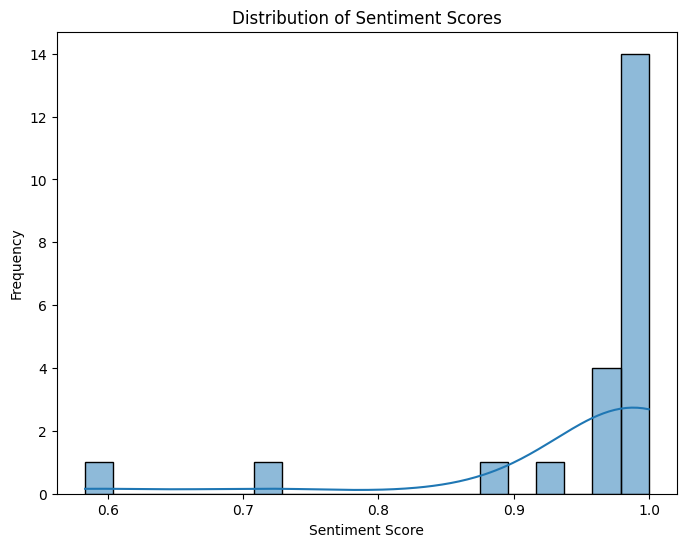

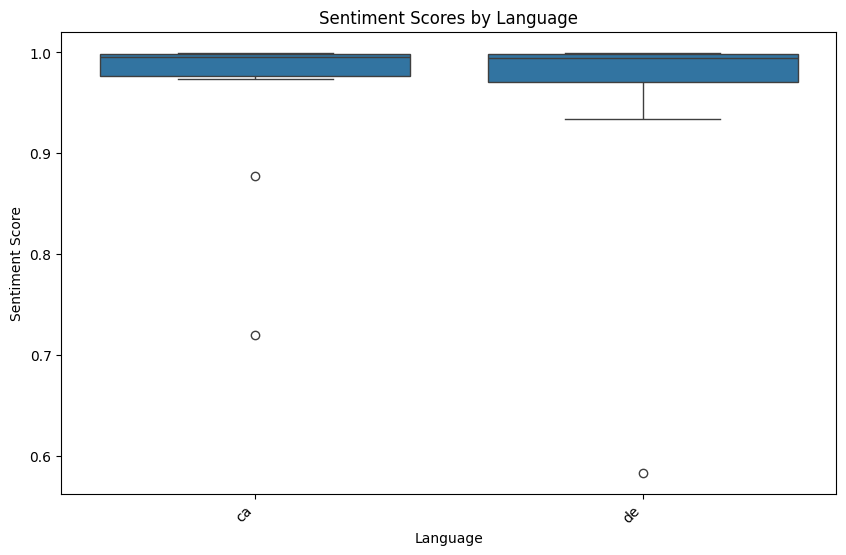

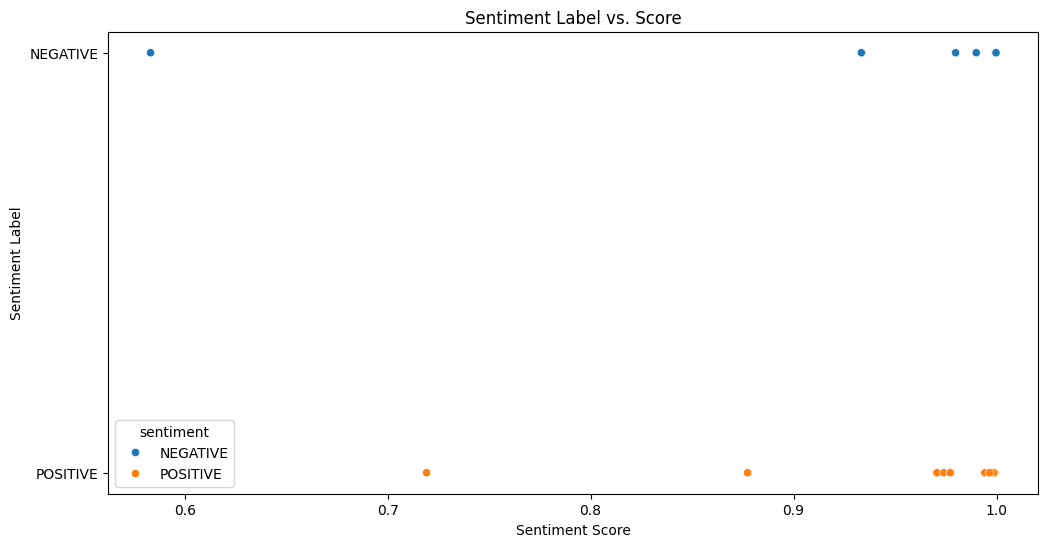

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Convert the string representation of dictionaries to actual dictionaries
result_df['sentiment'] = result_df['sentiment'].apply(ast.literal_eval)

# Extract labels and scores
result_df['sentiment_label'] = result_df['sentiment'].apply(lambda x: x['label'])
result_df['sentiment_score'] = result_df['sentiment'].apply(lambda x: x['score'])

# Plotting
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_label', data=result_df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(x='sentiment_score', data=result_df, hue='sentiment_label', kde=True)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

# Grouped bar plot for sentiment by language
plt.figure(figsize=(12, 6))
sns.countplot(x='language', hue='sentiment_label', data=result_df)
plt.title('Sentiment Distribution by Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


# Box plot for sentiment score by language
plt.figure(figsize=(12, 6))
sns.boxplot(x='language', y='sentiment_score', data=result_df, hue='sentiment_label')
plt.title('Sentiment Score Distribution by Language')
plt.xlabel('Language')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
